# Testing time marching in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Dyn3d"), "src/Dyn3d.jl"))
using Dyn3d
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Constrained system with integrating factor

Now let's do a more interesting example: 2-d diffusion from a circle

In [16]:
nx = 129; ny = 129;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [17]:
n = 128;
θ = linspace(0,2π,n+1);
R = 0.5;
xb = 1.0 + R*cos.(θ[1:n])
yb = 1.0 + R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f = ScalarData(X);

In [18]:
E = Regularize(X,dx;ddftype=Fields.Roma,issymmetric=true)
Hmat, Emat = RegularizationMatrix(E,f,w);

In [19]:
plan_constraints(u::Nodes{Dual,nx,ny},t::Float64) = Hmat, Emat

plan_constraints (generic function with 1 method)

In [20]:
Whirl.TimeMarching.r₁(w::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = Nodes(T,w)
Whirl.TimeMarching.r₂(w::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = ScalarData(ones(length(f)))

In [21]:
Δt = 0.01
ifherk = IFHERK(w,f,Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=RK31)

Order-3+ IF-HERK integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,129,129}
   Force of type Whirl.Fields.ScalarData{128}
   Time step size 0.01


In [22]:
@time ifherk.S[1].B₂A⁻¹(w)
@time ifherk.S[1].S*f;
@time ifherk.S[1].A⁻¹B₁ᵀ(f);

  0.014739 seconds (430 allocations: 184.118 KiB)
  0.020625 seconds (33 allocations: 450.172 KiB)
  0.014258 seconds (14 allocations: 287.875 KiB)


In [23]:
@time ifherk(0.0,w)

  7.243817 seconds (125.93 k allocations: 178.965 MiB, 0.35% gc time)


(0.01, Whirl.Fields.Dual nodes in a (nx = 129, ny = 129) cell grid
  Number of Whirl.Fields.Dual nodes: (nx = 129, ny = 129), 128 points of scalar-valued data
)

In [24]:
t = 0.0
w = Nodes(Dual,(nx,ny));

In [25]:
@time for i = 1:20
    t,w,f = ifherk(t,w);
end

140.790456 seconds (287.98 k allocations: 3.387 GiB, 0.23% gc time)


In [26]:
w.data[65,30:40]

11-element Array{Float64,1}:
 0.00258743 
 0.0338497  
 0.290042   
 1.2018     
 0.729853   
 0.109484   
 0.00957288 
 0.000582963
 2.71136e-5 
 1.01796e-6 
 3.20045e-8 

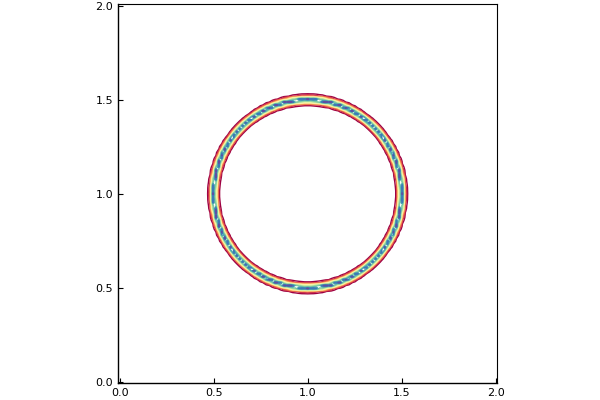

In [28]:
xg, yg = coordinates(w,dx=dx)
plot(xg,yg,w)

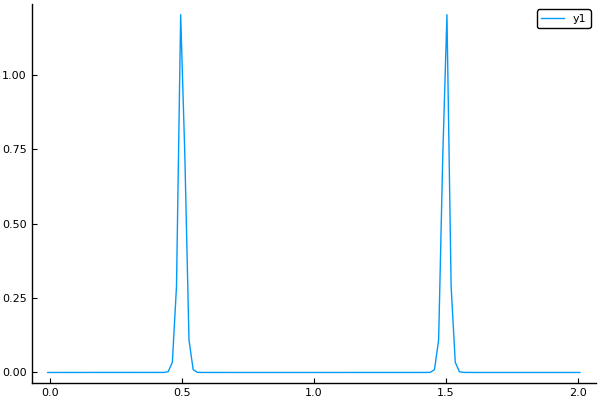

In [29]:
plot(xg,w[65,:])

### Solving basic unconstrained system with IFHERK

In [ ]:
ω = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω*t)/ω

In [ ]:
Δt = 0.005
T = 0:Δt:10
u = [u₀]
f = Vector{Float64}()
TimeMarching.r₁(u::Vector{Float64},t::Float64) = cos(ω*t)
TimeMarching.r₂(u::Vector{Float64},t::Float64) = Vector{Float64}()
plan_constraints(u::Vector{Float64},t::Float64) = f -> zeros(Float64,1), u -> Vector{Float64}()
Fields.plan_intfact(t::Float64,u::Vector{Float64}) = eye(1)
ifherk = IFHERK(u,f,Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=TimeMarching.RK31)

In [ ]:
u = [u₀]
uhist = Float64[]
for t in T
    push!(uhist,u[1])
    t,u,_ = ifherk(t,u)
end

In [ ]:
norm(uhist-uex.(T))

In [ ]:
plot(T,uhist)
plot!(T,uex.(T))

### Advancing a combination of non-integrating factor systems

In [ ]:
ω₁ = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω₁*t)/ω₁

In [ ]:
ω₂ = 2
v₀ = 0.5
vex(t) = v₀ + sin(ω₂*t)/ω₂

Note that r₁ receives the full tuple of states and returns a tuple

In [ ]:
Δt = 0.005
T = 0:Δt:10
u = ([u₀],[v₀])
TimeMarching.r₁(u::Tuple{Vector{Float64},Vector{Float64}},t::Float64) =  ([cos(ω₁*t)], [cos(ω₂*t)])
rk = RK(u,Δt,TimeMarching.r₁,rk=TimeMarching.RK31)

In [ ]:
u = ([u₀],[v₀])
u₁hist = Float64[]
u₂hist = Float64[]
for t in T
    push!(u₁hist,u[1][1])
    push!(u₂hist,u[2][1])
    t,u = rk(t,u)
end

In [ ]:
println("error for first element of tuple = ",norm(u₁hist-uex.(T)))
println("error for second element of tuple = ",norm(u₂hist-vex.(T)))

### Advancing a combination of integrating factor systems

In [ ]:
α₁ = 0.5
ω₁ = 4
u₀ = 1.0
uex(t) = u₀*exp(-α₁*t) + (α₁*(cos(ω₁*t)-exp(-α₁*t))+ω₁*sin(ω₁*t))/(α₁^2+ω₁^2)

In [ ]:
α₂ = 0.5
ω₂ = 2
v₀ = 0.5
vex(t) = v₀*exp(-α₂*t) + (α₂*(cos(ω₂*t)-exp(-α₂*t))+ω₂*sin(ω₂*t))/(α₂^2+ω₂^2)

In [ ]:
u = ([u₀],[v₀])

Set up the integrating factor constructor

In [ ]:
plan1_intfact(t::Float64,u::Vector{Float64}) = exp(-α₁*t)
plan2_intfact(t::Float64,u::Vector{Float64}) = exp(-α₂*t)

In [ ]:
Δt = 0.005
T = 0:Δt:10
u = ([u₀],[v₀])
TimeMarching.r₁(u::Tuple{Vector{Float64},Vector{Float64}},t::Float64) = ([cos(ω₁*t)], [cos(ω₂*t)])
ifrk = IFRK(u,Δt,(plan1_intfact,plan2_intfact),TimeMarching.r₁,rk=TimeMarching.RK31)

In [ ]:
u = ([u₀],[v₀])
u₁hist = Float64[]
u₂hist = Float64[]
for t in T
    push!(u₁hist,u[1][1])
    push!(u₂hist,u[2][1])
    t,u = ifrk(t,u)
end

In [ ]:
println("error for first element of tuple = ",norm(u₁hist-uex.(T)))
println("error for second element of tuple = ",norm(u₂hist-vex.(T)))

### Advancing a combination of constrained integrating factor system and basic system

System 1

In [ ]:
nx = 129; ny = 129;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [ ]:
n = 128;
θ = linspace(0,2π,n+1);
R = 0.5;
xb = 1.0 + R*cos.(θ[1:n])
yb = 1.0 + R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f1 = ScalarData(X);

System 2

In [ ]:
ω₁ = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω₁*t)/ω₁

Set up the state vector tuple and force tuple

In [ ]:
u = (w,[u₀])
f = (f1,Vector{Float64}())
TU = typeof(u)
TF = typeof(f)

In [ ]:
E = Regularize(X,dx;issymmetric=true)
Hmat, Emat = RegularizationMatrix(E,f1,w);

Set up the operators

In [ ]:
TimeMarching.r₁(u::TU,t::Float64) = (Nodes(Dual,w),[cos(ω₁*t)])
TimeMarching.r₂(u::TU,t::Float64) = (ScalarData(ones(length(f1))),Vector{Float64}())
plans = (Fields.plan_intfact,(t,u) -> eye(1))
plan_constraints(u::TU,t::Float64) = ((Hmat,f->zeros(Float64,1)),(Emat,u->Vector{Float64}()))

In [ ]:
Δt = 0.01
ifherk = IFHERK(u,f,Δt,plans,plan_constraints,(TimeMarching.r₁,TimeMarching.r₂),rk=TimeMarching.Euler,isstored=true)

In [ ]:
@time ifherk(0.0,u)

### Update operators in each stage